In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [54]:
seq_length = 50
seq_shift = 25
seq_overlap = 0


In [55]:
# READ CSV FILE, REMOVE NAN VALUES AND SPLIT INTO TWO DATAFRAMES
df = pd.read_csv('./temperature.csv')
df = df['New York']

# Remove nan values and convert to ndarray
df = df.dropna()
# df = df.reset_index()
seq = df.values

data_length = df.shape[0]

y_offset = seq_shift - seq_overlap
end_buffer = data_length - seq_length - y_offset

# Shift the sequence to get the input data and labels
x_seq = seq[:end_buffer]
y_seq = seq[y_offset + seq_length:]

train_proportion = 0.8
num_points = len(x_seq)
num_train_points = int(train_proportion * num_points)

## Create train and test datasets
x_seq_train = x_seq[:num_train_points]
y_seq_train = y_seq[:num_train_points]

x_seq_test = x_seq[num_train_points:]
y_seq_test = y_seq[num_train_points:]




## Create tensorflow graph for computation

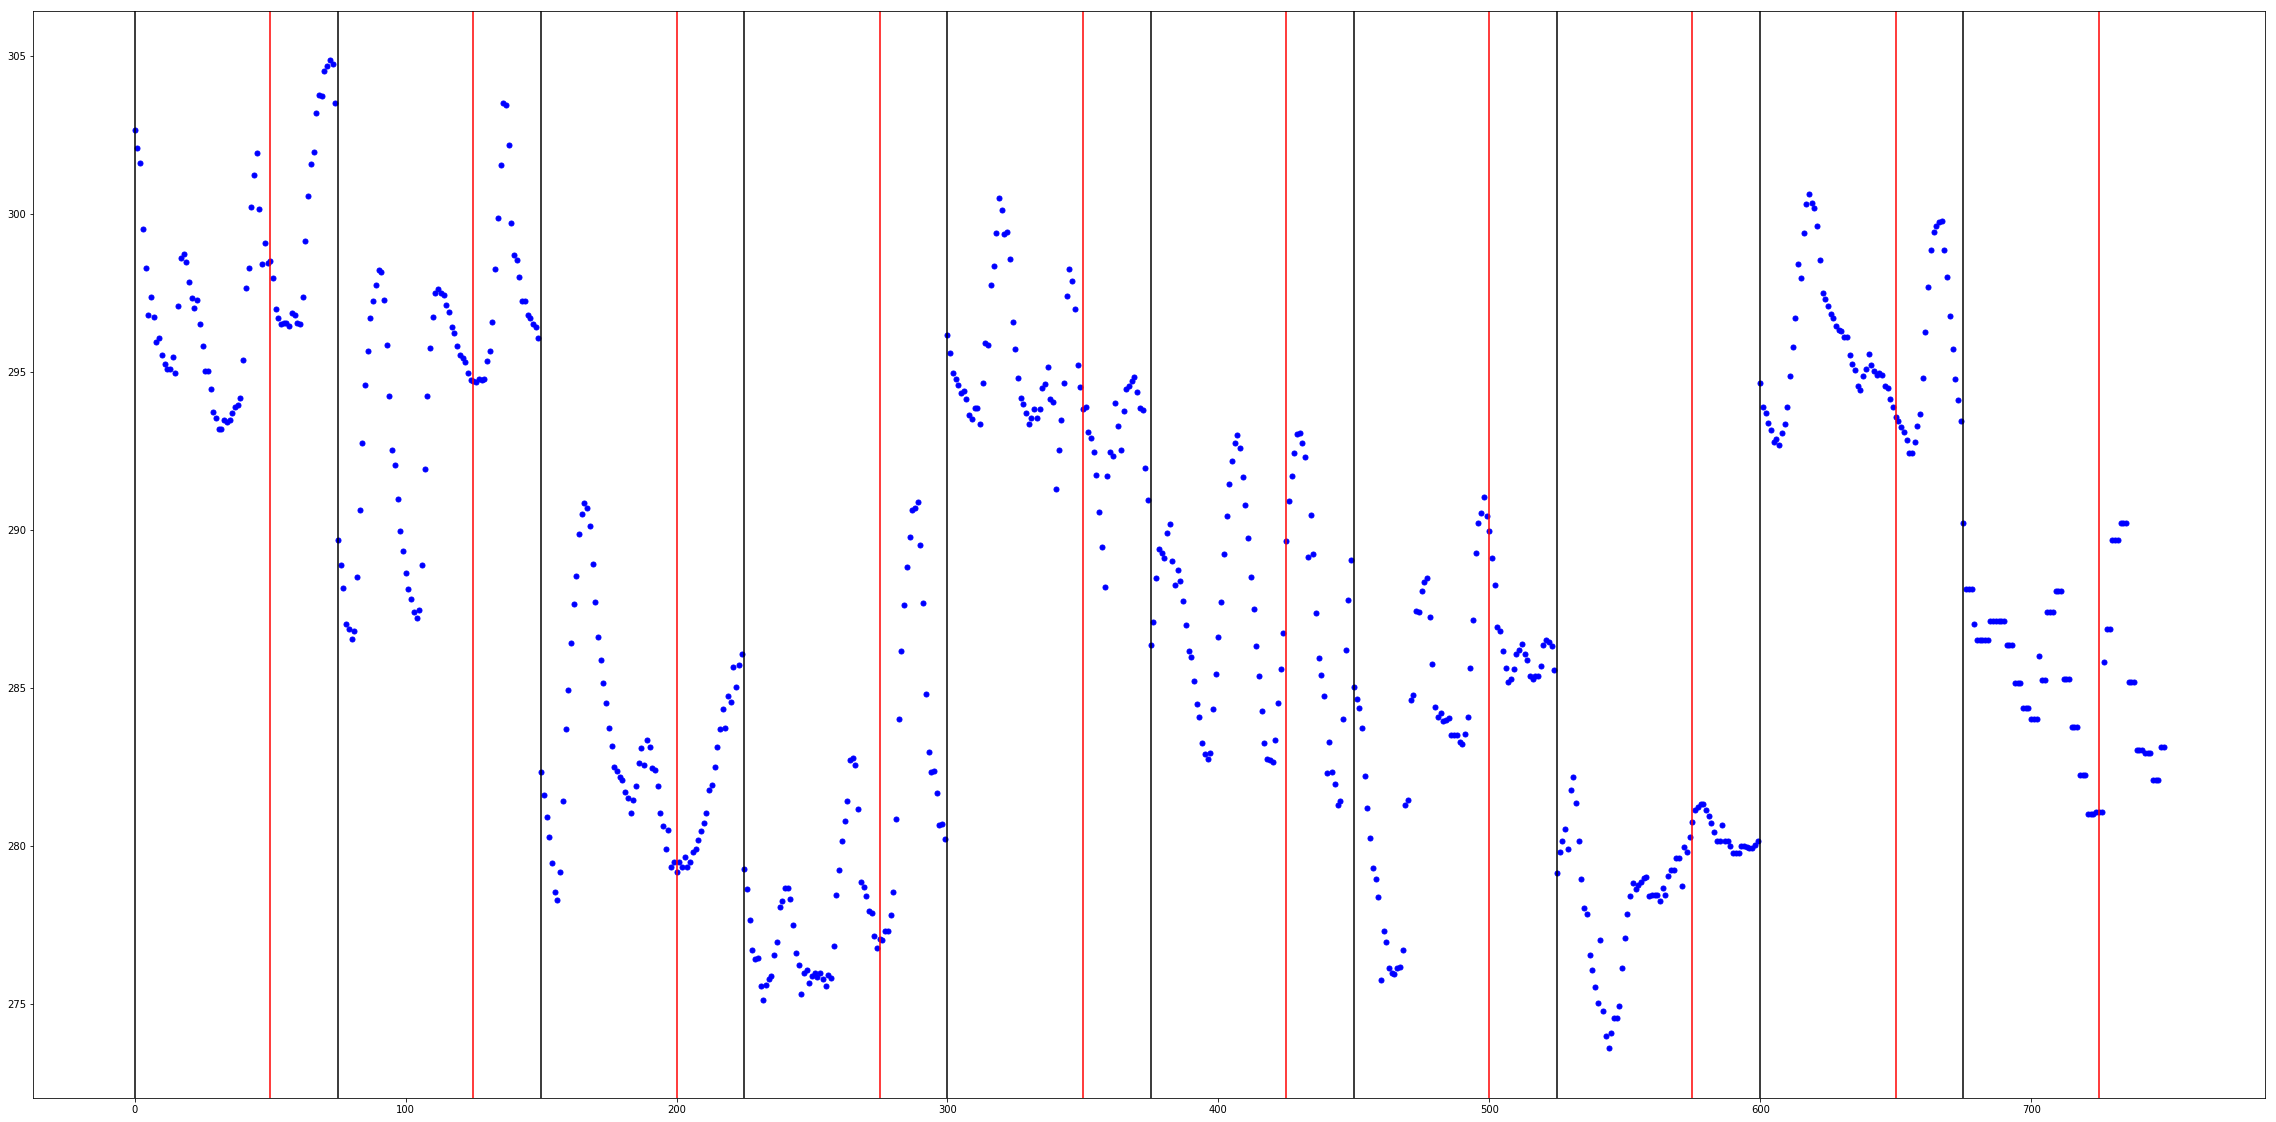

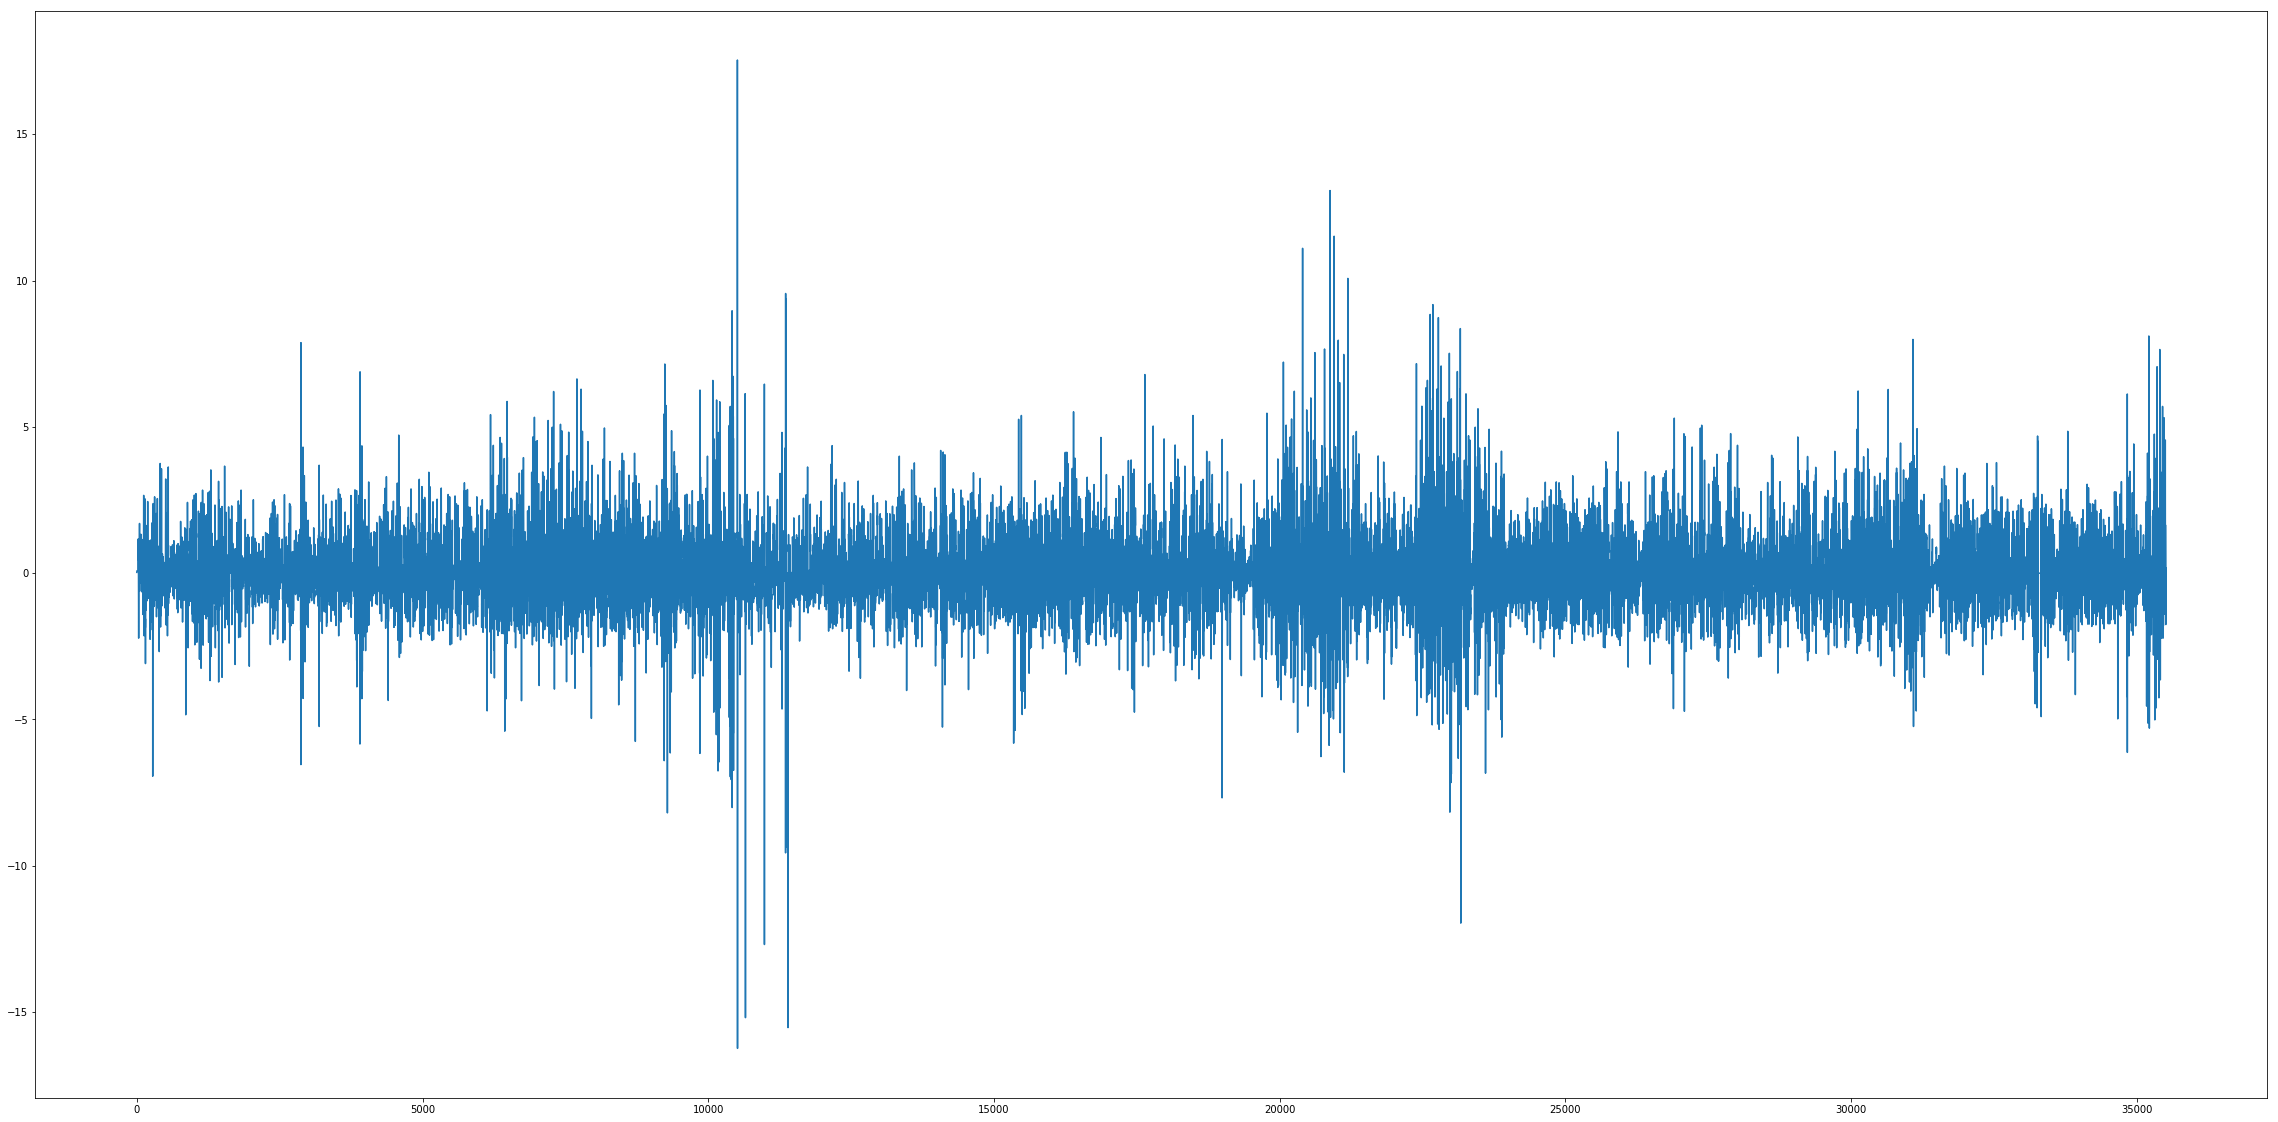

In [58]:

def get_minibatch(data_sequence, batch_size, seq_length, seq_shift, seq_overlap=0):
    """ Function to retrieve minibatches of sequences from a sequence of datapoints 

    Args:
        data_sequence: The total sequence of datapoints to sample from 
        batch_size:    The number of sequences in the returned minibatch
        seq_length:    The length of the sequence presented to the model, the x_sequence length
        seq_shift:     The number of time steps shifted from the x_sequence to get the y_sequence, the sequence the model will try to predict
        seq_overlap:   The number of time steps the x_seq and y_seq overlap

    Returns:
        seqs_x: batch_size number of sequences of length seq_length
        seqs_y: batch_size number of sequences of length seq_shift following the  values of seqs_x in data_sequences with 
                    seq_overlap number of overlapping values from the end of sequences in seq_x

    """
    
    data_length = len(data_sequence)
    # Get batch_size random numbers being indices where the sequences start. 
    end_buffer = data_length - seq_length - seq_shift + seq_overlap # Make sure no index is to close to the end to get outofbounds error
    indices = np.random.uniform(0, end_buffer, size=batch_size)     # Sample random positions in data_sequence
    indices = list(map(lambda x: int(x), indices))                  # Make positions integer indices
    
    # Store sequences of size seq_length starting at the found indices
    seqs_x = np.array([data_sequence[idx:idx + seq_length] for idx in indices])
    
    # Store sequences of length seq_shift that immidietly follow the sequences in seqx
    # These are the sequences to be predicted by the model
    y_offset = seq_length - seq_overlap # offset y_seq at end of x_seq minus the overlap
    seqs_y = np.array([data_sequence[idx + y_offset:idx + y_offset + seq_shift] for idx in indices])
    
    return seqs_x, seqs_y


# Test minibatch function
x_seq_batch, y_seq_batch = get_minibatch(x_seq_train, 10,  seq_length, seq_shift)

### Visualize the sequences
plt.rcParams['figure.figsize'] = [40, 20]
# Append x and y sequences
appended_vals = []
for x, y, in zip(x_seq_batch, y_seq_batch):
    appended_vals.append(np.concatenate((x, y), axis=0))

# Plot one time series by reveling the sequences
plt.plot(pd.Series(np.ravel(appended_vals)), 'b.', markersize=10, label='actual')

# Get coordinates for the start of x and y sequences
seq_coords   = np.array([x for x in range(0, len(np.ravel(appended_vals)), seq_length + seq_shift - seq_overlap)])
shift_coords = seq_coords + seq_length - seq_overlap

# Plot vertical lines at start of x and y sequences
for seq, shift in zip(seq_coords, shift_coords):
    plt.axvline(x=seq, color='k')
    plt.axvline(x=shift, color='r')

plt.show()



plt.plot(np.diff(x_seq_train, 1))
plt.show()

In [57]:
tf.reset_default_graph() # Reset previous running graphs

inputs = 1
outputs = 1

X = tf.placeholder(tf.float32, [None, seq_length, inputs])
Y = tf.placeholder(tf.float32, [None, seq_shift, outputs])

hidden_units = 512
learning_rate = 0.001
#https://towardsdatascience.com/seq2seq-model-in-tensorflow-ec0c557e560f

rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden_units, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(rnn_cell, X, dtype=tf.float32)
print(rnn_output.shape)

# # create 2 LSTMCells
# rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [128, 256, seq_shift]]

# # create a RNN cell composed sequentially of a number of RNNCells
# multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)

# # 'outputs' is a tensor of shape [batch_size, max_time, 256]
# # 'state' is a N-tuple where N is the number of LSTMCells containing a
# # tf.contrib.rnn.LSTMStateTuple for each cell
# outputs, state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
#                                    inputs=data,
#                                    dtype=tf.float32)



stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden_units])
stacked_outputs = tf.layers.dense(stacked_rnn_output, outputs)

print(stacked_outputs.shape)
out = tf.reshape(stacked_outputs, [-1, seq_shift, outputs])

print(out.shape)

loss = tf.reduce_sum(tf.square(out - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

(?, 50, 512)
(?, 1)
(?, 25, 1)


## Training time

In [30]:
epochs = 1000

num_batches = 10000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    

    for it in range(num_batches):
        
        x_seq_batch, y_seq_batch = get_minibatch(x_seq, 32,  seq_length, seq_shift)
        
        x_seq_batch = np.reshape(x_seq_batch, [-1, seq_length, outputs])
        y_seq_batch = np.reshape(y_seq_batch, [-1, seq_shift, outputs])
        
        
        

        sess.run(training_op, feed_dict={X:x_seq_batch, Y:y_seq_batch})

        if it % 100 == 0:
            mse = sess.run(loss, feed_dict={X:X_test, Y:Y_test})
            print(it, '\tMSE:', mse)
    y_pred_test = sess.run(out, feed_dict={X:X_test})


0 	MSE: 105191210.0
100 	MSE: 1495417.8
200 	MSE: 180302.05
300 	MSE: 57271.027
400 	MSE: 55071.438
500 	MSE: 53089.82
600 	MSE: 50802.08
700 	MSE: 53476.14
800 	MSE: 50785.023
900 	MSE: 59998.43
1000 	MSE: 62462.03
1100 	MSE: 55850.15
1200 	MSE: 53682.375
1300 	MSE: 60269.15
1400 	MSE: 52417.195
1500 	MSE: 50453.215
1600 	MSE: 97540.85
1700 	MSE: 56491.992
1800 	MSE: 53611.555
1900 	MSE: 48840.6
2000 	MSE: 47966.355
2100 	MSE: 54958.152
2200 	MSE: 48836.285
2300 	MSE: 69126.88
2400 	MSE: 47785.766
2500 	MSE: 46678.383
2600 	MSE: 46710.758
2700 	MSE: 55247.254
2800 	MSE: 57754.332
2900 	MSE: 48215.1
3000 	MSE: 48171.5
3100 	MSE: 73843.1
3200 	MSE: 50021.94
3300 	MSE: 73118.61
3400 	MSE: 66213.16
3500 	MSE: 73798.54
3600 	MSE: 45685.566
3700 	MSE: 45356.08
3800 	MSE: 56784.094
3900 	MSE: 46507.664
4000 	MSE: 54527.656
4100 	MSE: 45323.113
4200 	MSE: 50934.27
4300 	MSE: 49587.72
4400 	MSE: 53059.426
4500 	MSE: 47782.55
4600 	MSE: 53059.47
4700 	MSE: 68496.12
4800 	MSE: 48944.38
4900 	MSE

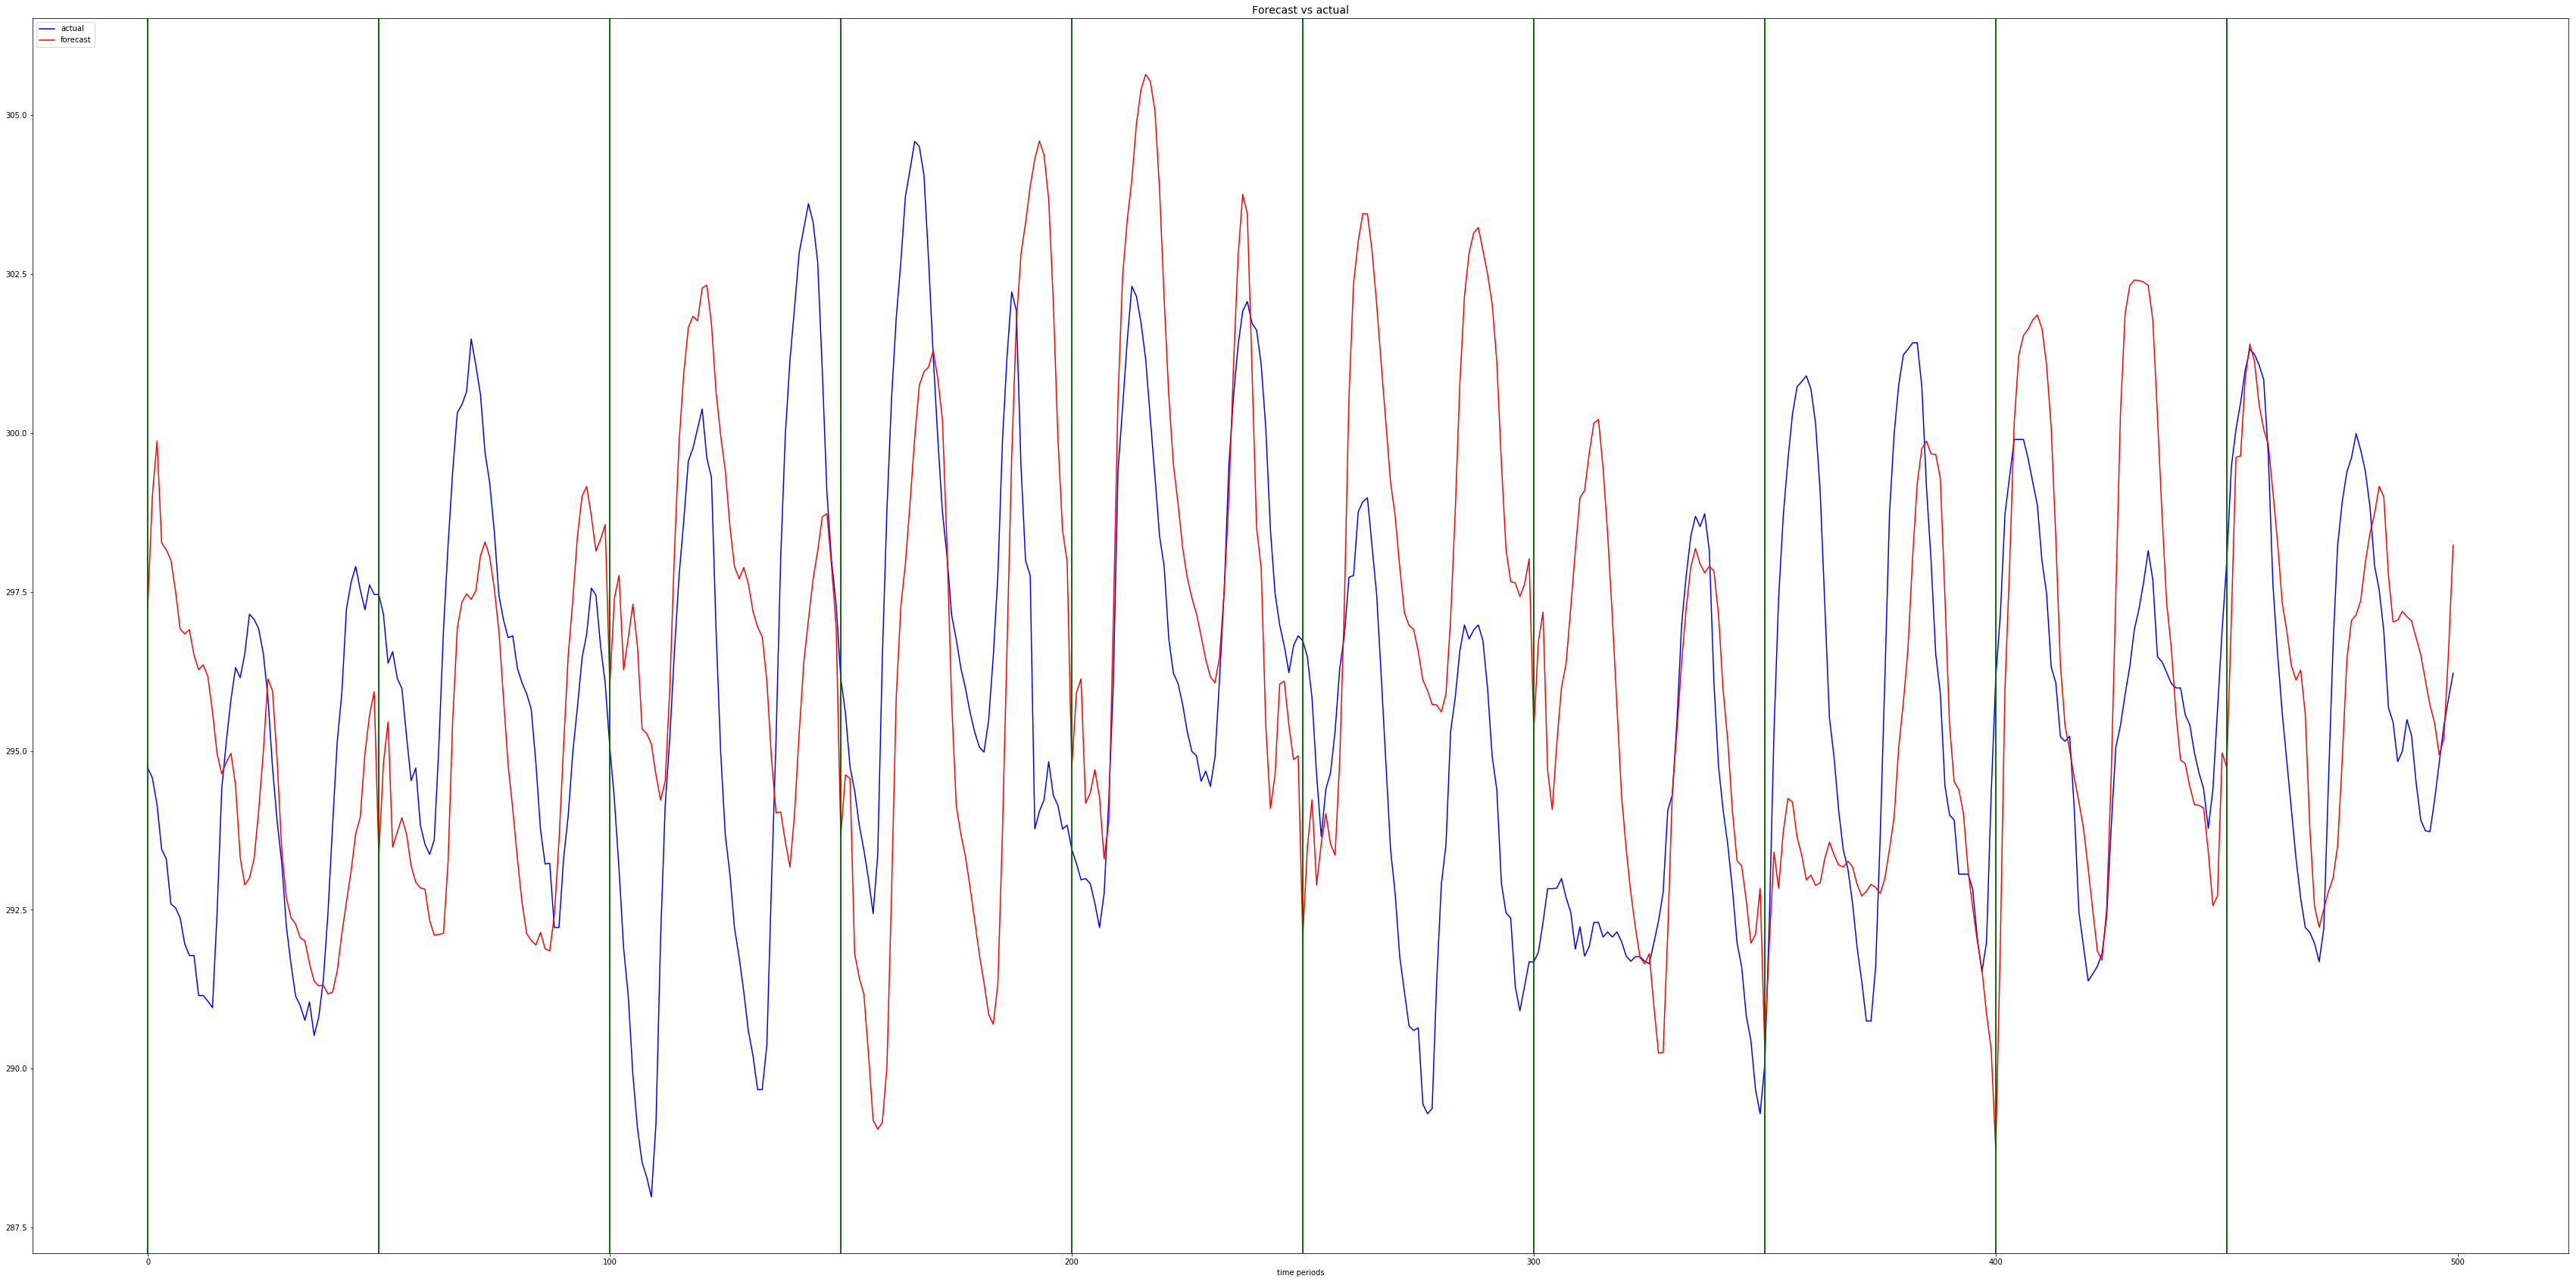

In [35]:
plt.rcParams['figure.figsize'] = [60, 30]

plt.title('Forecast vs actual', fontsize=14)

#plt.plot(pd.Series(np.ravel(Y_train)), 'y', markersize=10, label='actual')
#plt.plot(pd.Series(np.ravel(y_pred_train)), 'g', markersize=10, label='actual')


plt.plot(pd.Series(np.ravel(Y_test)[:500]), 'b', markersize=10, label='actual')
plt.plot(pd.Series(np.ravel(y_pred_test)[:500]), 'r', markersize=10, label='forecast')


xcoords = np.array([x for x in range(0, len(np.ravel(Y_test)[:500]), seq_length)])
xcoords2 = xcoords + seq_length - seq_shift

for xc in xcoords:
    plt.axvline(x=xc, color='k')

for xc in xcoords2:
    plt.axvline(x=xc, color='g')


plt.legend(loc='upper left')
plt.xlabel('time periods')

plt.show()